# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [70]:
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


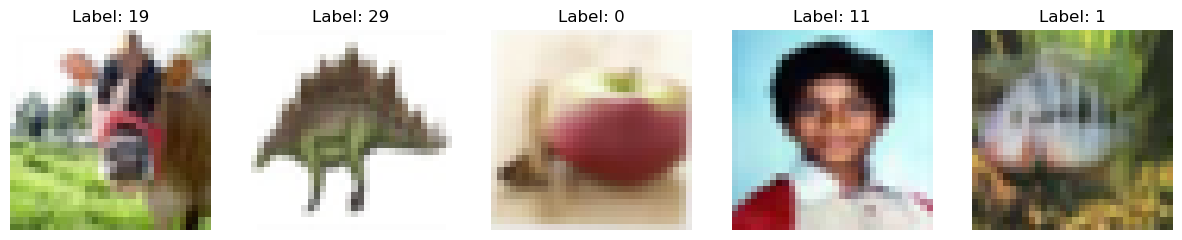

In [71]:
# Your code here
import matplotlib.pyplot as plt
import numpy as np

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [72]:
# Your code here
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Divide by 255 to noramlize between 0 and 1 
x_test = x_test.astype('float32') /255
x_train = x_train.astype('float32')/255

# One hot encoding the target (y) data set, since there are 100 class we set the one hot to 100  
y_test = to_categorical(y_test,100) 
y_train = to_categorical(y_train,100)

# split training into validation sets 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

print(x_test.shape)

(10000, 32, 32, 3)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [75]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Your code here

model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Dropout(0.5))

# Add a classifier on top of CNN
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 conv2d_57 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 conv2d_59 (Conv2D)          (None, 10, 10, 128)       147584    
                                                     

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [78]:
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Your code here
# model needs to classify input data into one of multiple classes so I used categorical_crossentropy and use Adam as it is commonly used.

optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(x_train)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.2, min_lr= 1e-5)



## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [79]:
# Your code here
# Trial and error to the epoch at first but then I coded for an early end if the rates plateau
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stop,rlrop])

Epoch 1/20
1250/1250 [==============================] - 209s 167ms/step - loss: 4.4329 - accuracy: 0.0248 - val_loss: 4.1365 - val_accuracy: 0.0620 - lr: 1.0000e-04
Epoch 2/20
1250/1250 [==============================] - 351s 281ms/step - loss: 4.0157 - accuracy: 0.0786 - val_loss: 3.7531 - val_accuracy: 0.1254 - lr: 1.0000e-04
Epoch 3/20
1250/1250 [==============================] - 323s 258ms/step - loss: 3.7748 - accuracy: 0.1159 - val_loss: 3.5325 - val_accuracy: 0.1641 - lr: 1.0000e-04
Epoch 4/20
1250/1250 [==============================] - 345s 276ms/step - loss: 3.6170 - accuracy: 0.1408 - val_loss: 3.4056 - val_accuracy: 0.1761 - lr: 1.0000e-04
Epoch 5/20
1250/1250 [==============================] - 367s 293ms/step - loss: 3.4885 - accuracy: 0.1614 - val_loss: 3.3152 - val_accuracy: 0.1986 - lr: 1.0000e-04
Epoch 6/20
1250/1250 [==============================] - 369s 295ms/step - loss: 3.3731 - accuracy: 0.1825 - val_loss: 3.1676 - val_accuracy: 0.2362 - lr: 1.0000e-04
Epoch 7/20

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> ______
- <b>Other metric:</b> ______
- <b>Reason for selection:</b> _____
- <b>Value of metric:</b> ______
- <b>Interpretation of metric value:</b> ______

In [81]:
# Your code here

# Continue training the model for an additional 20 epochs
additional_history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                               steps_per_epoch=len(x_train) // 32,
                               epochs=40,
                               validation_data=(x_val, y_val),
                               callbacks=[early_stop, rlrop])


Epoch 1/40
1250/1250 [==============================] - 221s 176ms/step - loss: 2.7136 - accuracy: 0.3142 - val_loss: 2.5026 - val_accuracy: 0.3582 - lr: 1.0000e-04
Epoch 2/40
1250/1250 [==============================] - 313s 250ms/step - loss: 2.6663 - accuracy: 0.3207 - val_loss: 2.4498 - val_accuracy: 0.3701 - lr: 1.0000e-04
Epoch 3/40
1250/1250 [==============================] - 369s 295ms/step - loss: 2.6299 - accuracy: 0.3262 - val_loss: 2.4880 - val_accuracy: 0.3654 - lr: 1.0000e-04
Epoch 4/40
1250/1250 [==============================] - 332s 266ms/step - loss: 2.6055 - accuracy: 0.3305 - val_loss: 2.4556 - val_accuracy: 0.3735 - lr: 1.0000e-04
Epoch 5/40
1250/1250 [==============================] - 307s 246ms/step - loss: 2.5738 - accuracy: 0.3362 - val_loss: 2.3938 - val_accuracy: 0.3859 - lr: 1.0000e-04
Epoch 6/40
1250/1250 [==============================] - 342s 273ms/step - loss: 2.5304 - accuracy: 0.3492 - val_loss: 2.3632 - val_accuracy: 0.3890 - lr: 1.0000e-04
Epoch 7/40

In [83]:
additional_history_2 = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                               steps_per_epoch=len(x_train) // 32,
                               epochs=70,
                               validation_data=(x_val, y_val),
                               callbacks=[early_stop, rlrop])

def combine_histories(history1, history2, history3):
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key] + history3.history[key]
    return combined_history

combined_history = combine_histories(history, additional_history, additional_history_2)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

from sklearn.metrics import precision_score

y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision: {precision}")

Epoch 1/70
1250/1250 [==============================] - 285s 228ms/step - loss: 1.9321 - accuracy: 0.4737 - val_loss: 1.9996 - val_accuracy: 0.4729 - lr: 1.0000e-05
Epoch 2/70
1250/1250 [==============================] - 303s 242ms/step - loss: 1.9271 - accuracy: 0.4778 - val_loss: 2.0081 - val_accuracy: 0.4745 - lr: 1.0000e-05
Epoch 3/70
1250/1250 [==============================] - 313s 250ms/step - loss: 1.9250 - accuracy: 0.4747 - val_loss: 2.0039 - val_accuracy: 0.4757 - lr: 1.0000e-05
Epoch 4/70
1250/1250 [==============================] - 317s 253ms/step - loss: 1.9244 - accuracy: 0.4751 - val_loss: 2.0001 - val_accuracy: 0.4727 - lr: 1.0000e-05
Epoch 5/70
1250/1250 [==============================] - 342s 273ms/step - loss: 1.9267 - accuracy: 0.4763 - val_loss: 2.0039 - val_accuracy: 0.4746 - lr: 1.0000e-05
Epoch 6/70
1250/1250 [==============================] - 290s 232ms/step - loss: 1.9253 - accuracy: 0.4753 - val_loss: 1.9955 - val_accuracy: 0.4790 - lr: 1.0000e-05
Epoch 7/70

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

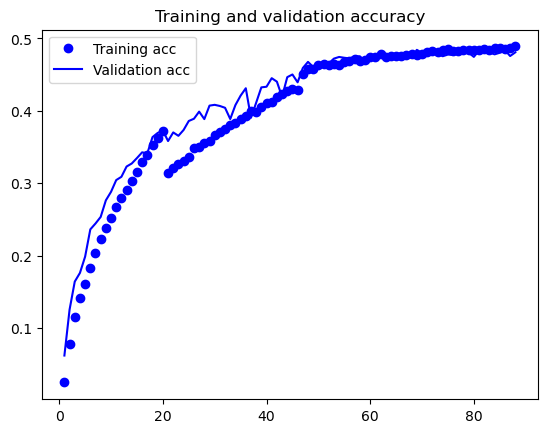

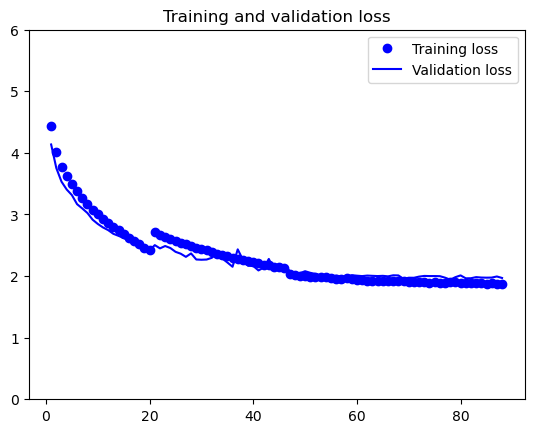

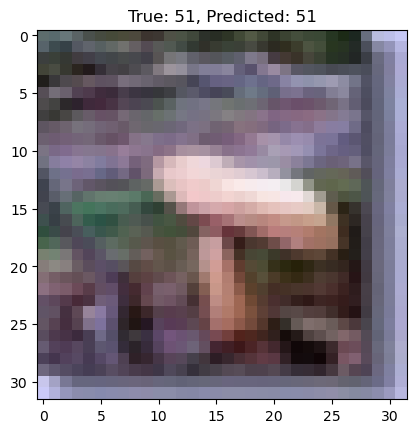

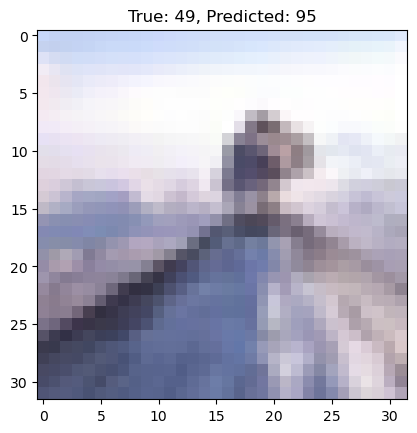

In [96]:
# Your code here
from tensorflow.keras.models import save_model, load_model

def training_plot(history):
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.ylim(0,6)
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

training_plot(combined_history)

correct_idx = np.where(y_pred == y_true)[0]
incorrect_idx = np.where(y_pred != y_true)[0]

plt.imshow(x_test[correct_idx[0]])
plt.title(f"True: {y_true[correct_idx[0]]}, Predicted: {y_pred[correct_idx[0]]}")
plt.show()

plt.imshow(x_test[incorrect_idx[0]])
plt.title(f"True: {y_true[incorrect_idx[0]]}, Predicted: {y_pred[incorrect_idx[0]]}")
plt.show()

model.save('feature_focused_model.h5')


## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [ ]:
# Your code here
# I wrote it below, sorry


### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [114]:
# Your code here
# Create an ImageDataGenerator instance with the augmentations --> Test-Time Augmentations.
tta_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

def tta_predict(model, x_test, num_augmentations=10):
    tta_preds = []
    for _ in range(num_augmentations):
        augmented_images = tta_datagen.flow(x_test, batch_size=x_test.shape[0], shuffle=False)
        tta_preds.append(model.predict(augmented_images[0]))
    return np.mean(tta_preds, axis=0)

tta_predictions = tta_predict(model, x_test, num_augmentations=100)
tta_pred_classes = np.argmax(tta_predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

tta_accuracy = np.mean(tta_pred_classes == true_classes)
print(f"TTA test accuracy: {tta_accuracy}")


313/313 [==============================] - 16s 51ms/step
TTA test accuracy: 0.527


### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here
Yes the accuracy imporve by 10%, there is great deal of improvement that could be made to the model architecture, but I dont have the run capacity or patience. Test-Time Augmentation makes predictions more robust by considering multiple augmented versions of the input images. As well helping with generalization. 



## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.